# Data Preprocessing

In this notebook, we will demonstrate practical examples of all the BiaPy preprocessing functions, including their parameters in both 2D and 3D. It is designed to be interactive, allowing the user to experiment with different values and functions.

**Contact:** This notebook was created by [Aitor González-Marfil](mailto:aitor.gonzalezm@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!

## Arrangements

In [ ]:
#@markdown ##Play to install BiaPy and its dependences
# Install latest release of BiaPy
!pip install biapy==3.6.5

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

# Finally install some packages that rely on the Pytorch installation
!pip install timm==1.0.14 pytorch-msssim torchmetrics[image]==1.4.*


import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output
from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.6/434.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
#@markdown ##Play to load utilities
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, Layout, HBox, Output

def plot_images(display_list, title = None, custom_size=False, save_fig_path='', mode = 'gray'):
    if not custom_size:
        plt.figure(figsize=(5*len(display_list), 5))

    if not title:
        title = ['Input Image', 'True Mask', 'Predicted Mask', 'Raw Predicted Mask'] # default

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], mode)
        #plt.axis('off')
    if save_fig_path:
        plt.savefig(save_fig_path)
    else:
        plt.show()

def interactive_3d_viewer(X, Y, prefix=''):
    # Initialize widgets

    # Slider widget to choose Z value
    sliderZ= IntSlider(
        value=0,
        min=1,
        max=len(X),
        step=1,
        description='Z value:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        layout=Layout(width='500px', margin = '0 0 0 10px')
    )

    sliderZ.style.description_width = 'initial'
    sliderZ.style.handle_color='blue'

    # Initialize Output instance to handle code output cell
    output = Output()

    # Function to display images depending on sliderZ value
    def display_images(change):
        with output:
            output.clear_output(wait=True)
            index = change['new']

            # Display images
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.title(f"{prefix} image, Z: {index}")
            plt.imshow(X[index-1], cmap='gray')

            if Y_test is not None: # If StopIteration exception was not thrown
                plt.subplot(1, 2, 2)
                plt.title("Label")
                plt.imshow(np.squeeze(Y[index-1]), cmap='gray', interpolation='nearest')

            else:
                print("No labels for this set.")
            plt.show()

    # Create an HBox to hold the dropdown and slider
    controls = HBox([sliderZ])
    display(controls, output)

    # Link widgets to functions
    sliderZ.observe(display_images, names='value')

    # Initial display
    display_images({'new': sliderZ.value})

In [ ]:
#@markdown ##Play to download an example dataset
#@markdown Simply execute the following cell to download a sample dataset.
#@markdown
#@markdown Specifically, we'll use the [Electron Microscopy Dataset (EPFL - CVLAB)](https://www.epfl.ch/labs/cvlab/data/data-em/) which is publicly available online.

import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=10Cf11PtERq4pDHCJroekxu_hf10EZzwG", "fibsem_epfl.zip", quiet=True)

!unzip -q fibsem_epfl.zip
!rm fibsem_epfl.zip

print( 'Dataset downloaded and unzipped under /content/data')

Dataset downloaded and unzipped under /content/data


In [ ]:
#@markdown ##Play to load dataset

import numpy as np

from biapy.config.config import Config
from biapy.data.pre_processing import preprocess_data
from biapy.data.data_manipulation import load_data_from_dir #, load_3d_images_from_dir

# Get default config
cfg = Config(job_dir='./test_data_preprocessing/', job_identifier='Experiment_1')
cfg = cfg.get_cfg_defaults()

# set data path and patch size
cfg.DATA.TEST.PATH = '/content/data/train/raw'
cfg.DATA.TEST.GT_PATH = '/content/data/train/label'
cfg.DATA.PATCH_SIZE = (768, 1024, 1)

# preprocessing base configuration
prep_cfg = cfg.DATA.PREPROCESS
data_title = ['image 1', 'Label 1', 'image 2', 'Label 2']

# load data
X_test = load_data_from_dir(cfg.DATA.TEST.PATH, is_3d=True)
Y_test = load_data_from_dir(cfg.DATA.TEST.GT_PATH, is_3d=True)

if len(X_test) != len(Y_test):
    raise ValueError("Different number of raw and ground truth items ({} vs {}). "
        "Please check the data!".format(len(X_test), len(Y_test)))

# get first and last images as examples
x1,y1 = X_test[0][0], Y_test[0][0]
x2,y2 = X_test[0][-1], Y_test[0][-1]

# reduce 3d dataset to speed up this notebook
X_test, Y_test = X_test[0][:45,:768,:1024], Y_test[0][:45,:768,:1024]
print("Reduced 3d dataset shape:", X_test.shape)

Loading images from /content/data/train/raw . . .


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


Loading images from /content/data/train/label . . .


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

Reduced 3d dataset shape: (45, 768, 1024, 1)


## Data Processing

For the **2D examples**, we will work with the first and last slices of the dataset.

For the **3D examples**, we will work with a subset of the first 45 slices. To explore the 3D image, feel free to adjust the Z slider, which will help you navigate through different slices of the dataset.

From this point onward, each preprocessing function will follow this structure, including their respective parameters. You can experiment with different values to see how they affect the original image.

### Original Data

By running the following cells, we can see **raw downloaded data** samples, without any modifications.

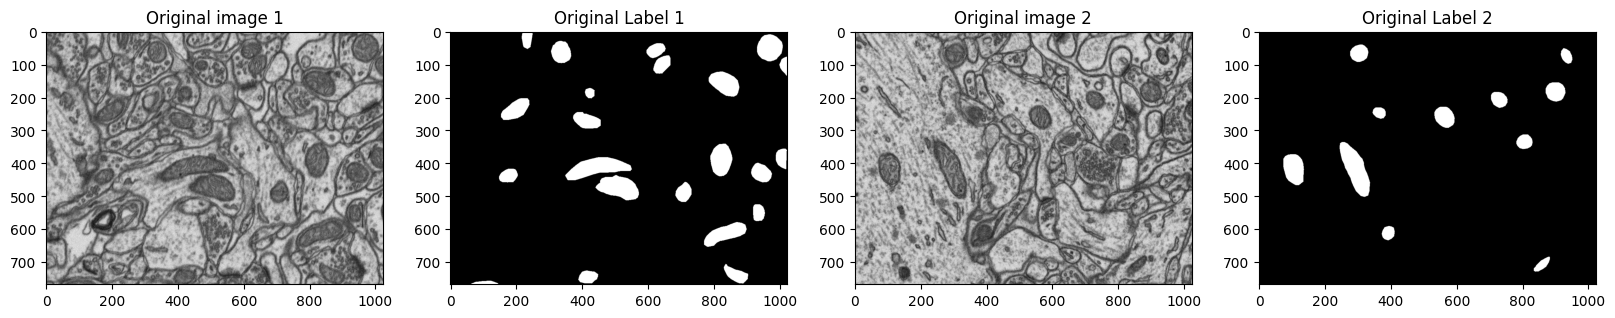

In [ ]:
# @markdown ## Original 2D data
config = prep_cfg.clone()
config_name = 'Original'

x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name} '+ s for s in data_title])

In [ ]:
# @markdown ## Original 3D data
config = prep_cfg.clone()
config_name = 'Original'

x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

Output()

### Resize

This function changes the dimensions of an image by scaling it to a new width and height. This can either enlarge or shrink the image while preserving the aspect ratio if specified.

Parameters:
* `OUTPUT_SHAPE`: Size of the generated output 2D (H,W) or 3D (Z,H,W) images.
* `ORDER`: The interpolation order. Available options are:
    * **0**: Nearest-neighbor
    * **1**: Bi-linear (default)
    * **2**: Bi-quadratic
    * **3**: Bi-cubic
    * **4**: Bi-quartic
    * **5**: Bi-quintic
* `MODE`: Points outside the boundaries of the input are filled according to the given mode.
* `CVAL`: The value that will be used outside the image boundaries when filling `mode` is `constant`.
* `CLIP`: Whether to clip the output to the range of values of the input image.
* `PRESERVE_RANGE`: Whether to keep the original range of values.
* `ANTI_ALIASING`: Whether to apply a Gaussian filter to smooth the image prior to downsampling.

More info: [Implementation](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)

In [ ]:
#@markdown ## Resize configuration
config = prep_cfg.clone()

config.RESIZE.ENABLE = True #@param {type:"boolean"}
# interpolation order: {0: Nearest-neighbor, 1: Bi-linear (default), 2: Bi-quadratic, 3: Bi-cubic, 4: Bi-quartic, 5: Bi-quintic}
config.RESIZE.ORDER = 1 #@param [1,2,3,4,5]
# Points outside the boundaries of the input are filled according to the given mode: {'constant', 'edge', 'symmetric', 'reflect', 'wrap'}
config.RESIZE.MODE = "reflect" #@param ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
# Used in conjunction with mode ‘constant’, the value outside the image boundaries.
config.RESIZE.CVAL = 0.0 #@param {type:"number"}
# Whether to clip the output to the range of values of the input image.
config.RESIZE.CLIP = True #@param {type:"boolean"}
# Whether to keep the original range of values.
config.RESIZE.PRESERVE_RANGE = True #@param {type:"boolean"}
# Whether to apply a Gaussian filter to smooth the image prior to downsampling.
config.RESIZE.ANTI_ALIASING = False #@param {type:"boolean"}

config_name = 'Resized'

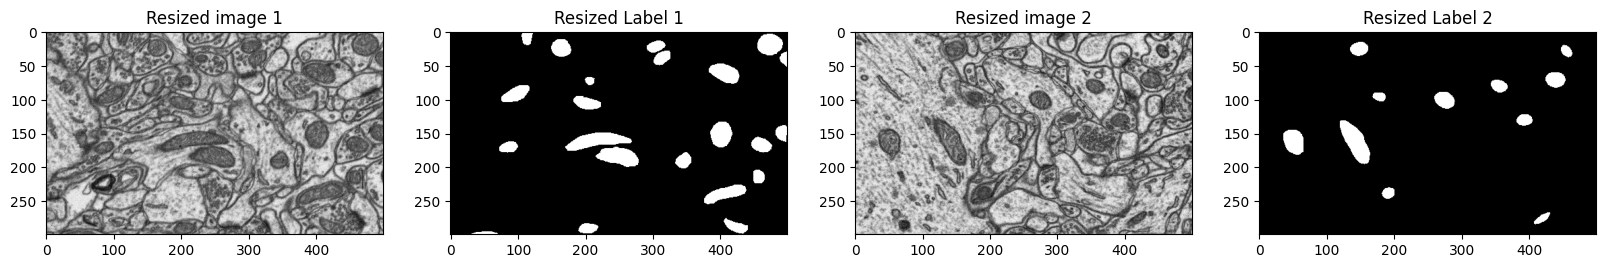

In [ ]:
#@markdown ## Resize image 2D
config.RESIZE.OUTPUT_SHAPE = (300, 500) #@param {type:"raw"}

x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name} '+ s for s in data_title])

In [ ]:
#@markdown ## Resize image 3D
config.RESIZE.OUTPUT_SHAPE = (30,300,500) #@param {type:"raw"}

x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

Output()

### Gaussian blur

This function applies a Gaussian filter to an image, which smooths the image by averaging the pixels in a neighborhood, weighted by a Gaussian distribution. This type of blur is commonly used to reduce noise, detail, or soften edges in an image.

Parameters:
* `SIGMA`: Standard deviation for Gaussian kernel.
* `MODE`: The mode parameter determines how the array borders are handled.
* `CHANNEL_AXIS`: Indicates which axis of the array corresponds to channels. If `None`, the image is assumed to be a grayscale (single channel) image.

More info: [Implementation](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian), [Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur)

In [ ]:
#@markdown ## Gaussian blur configuration
config = prep_cfg.clone()
config.GAUSSIAN_BLUR.ENABLE = True
config.GAUSSIAN_BLUR.SIGMA = 3 #@param {type:"number"}
# The mode parameter determines how the array borders are handled: {‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’} ‘constant’ value = 0
config.GAUSSIAN_BLUR.MODE = "nearest" #@param ["reflect", "constant", "nearest", "mirror", "wrap"]
# If None, the image is assumed to be a grayscale (single channel) image.
# Otherwise, this parameter indicates which axis of the array corresponds to channels.
config.GAUSSIAN_BLUR.CHANNEL_AXIS = None #@param {type:"raw"}

config_name = 'Gaussian blured'

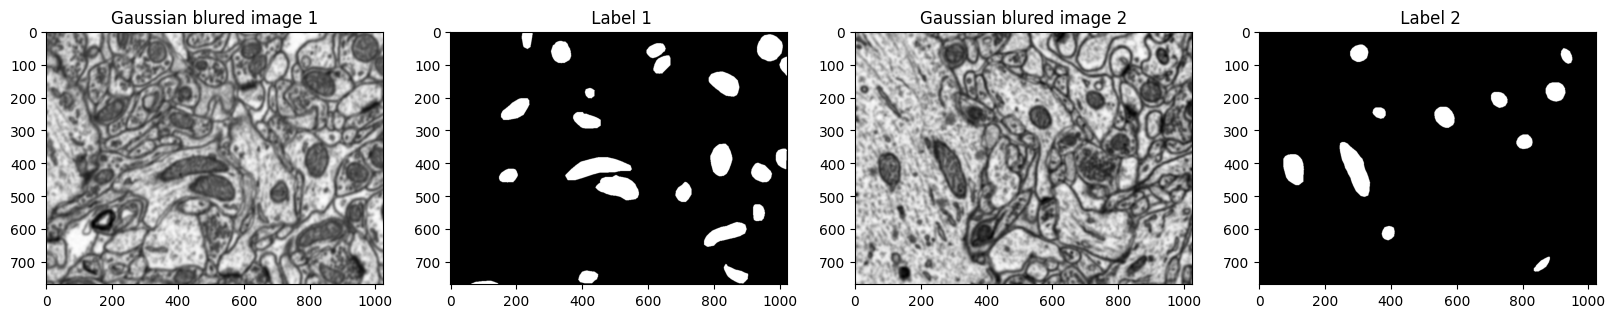

In [ ]:
#@markdown ## Gaussian blur image 2D
x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name if i%2==0 else ""} '+ s for i,s in enumerate(data_title)])

In [ ]:
#@markdown ## Gaussian blur image 3D
x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

Output()

### Median blur

This function reduces noise in an image by replacing each pixel's value with the median value of the pixels in its neighborhood. This method is particularly effective at removing "salt and pepper" noise, where individual pixels are randomly set to black or white, while preserving edges better than a simple average filter.

Parameters:

* `KERNEL_SIZE`:  Defines the desired kernel shape (taking into account channels). The kernel can be 2D (H, W, C) or 3D (Z, H, W, C).

More info: [Implementation](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.median), [Wikipedia](https://en.wikipedia.org/wiki/Median_filter)

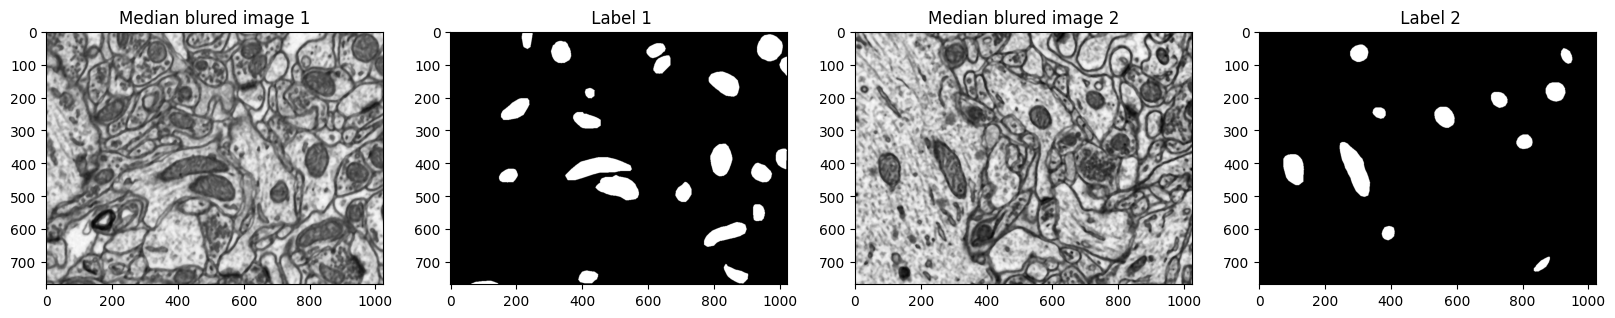

In [ ]:
#@markdown ## Median blur image 2D
config = prep_cfg.clone()
config.MEDIAN_BLUR.ENABLE = True
config.MEDIAN_BLUR.KERNEL_SIZE = (7, 7, 1) #@param  {type:"raw"}
config_name = 'Median blured'

x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name if i%2==0 else ""} '+ s for i,s in enumerate(data_title)])

In [ ]:
#@markdown ## Median blur image 3D
config = prep_cfg.clone()
config.MEDIAN_BLUR.ENABLE = True
kernel = (3, 5, 5, 1) #@param  {type:"raw"}
config.MEDIAN_BLUR.KERNEL_SIZE = kernel # np.ones(kernel, dtype=np.uint8).tolist()
config_name = 'Median blured'

x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

Output()

### CLAHE

This function enhances the contrast of an image by applying Adaptive Histogram Equalization (AHE) but limits the contrast enhancement to avoid amplifying noise. CLAHE works on small regions of the image, improving local contrast while maintaining overall brightness levels, making it useful in images with varying lighting conditions.

Parameters:

* `KERNEL_SIZE`: Defines the shape of contextual regions used in the algorithm. If `None`, kernel_size is 1/8 of image height by 1/8 of its width.
* `CLIP_LIMIT`: Clipping limit, normalized between 0 and 1 (higher values give more contrast).

More info: [Implementation](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.equalize_adapthist), [Wikipedia](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)

In [ ]:
#@markdown ## CLAHE configuration
config = prep_cfg.clone()
config.CLAHE.ENABLE = True
# Defines the shape of contextual regions used in the algorithm.
# By default, kernel_size is 1/8 of image height by 1/8 of its width.
config.CLAHE.KERNEL_SIZE = None #@param {type:"raw"}
# Clipping limit, normalized between 0 and 1 (higher values give more contrast).
config.CLAHE.CLIP_LIMIT = 0.01 #@param {type:"raw"}
config_name = 'CLAHE'

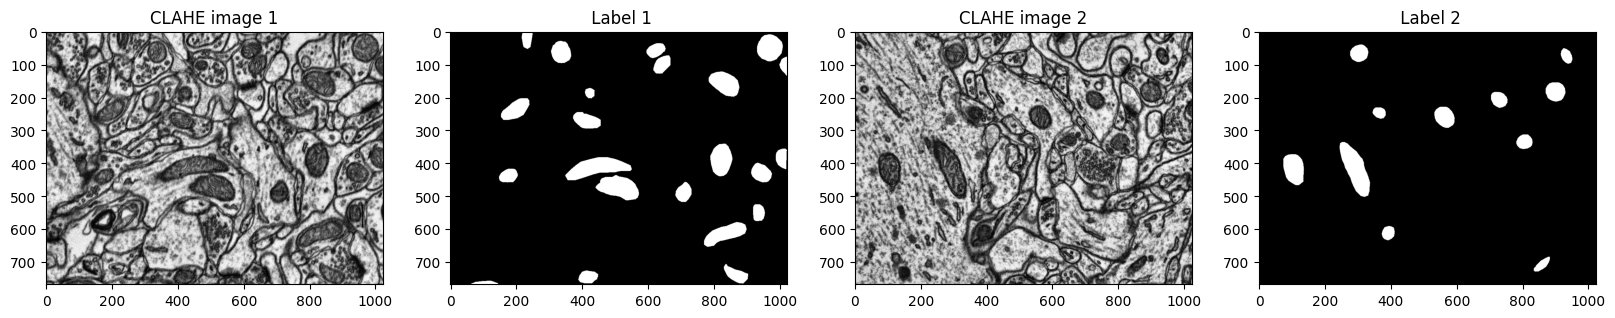

In [ ]:
#@markdown ## CLAHE image 2D
#@markdown We will use this image as reference for histogram matching. Therefore, run this before histogram matching.
x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name if i%2==0 else ""} '+ s for i,s in enumerate(data_title)])

# Save image for histogram matching
from skimage.io import imsave
import os
os.makedirs("/content/data/hist_match/", exist_ok=True)
imsave("/content/data/hist_match/image_with_clahe.tif", x[0])

In [ ]:
#@markdown ## CLAHE image 3D
x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

Output()

### Histogram matching

This function adjusts the pixel values of one image to match the histogram (distribution of pixel intensities) of another image. This technique is often used to correct or standardize the exposure or contrast of images, making them more consistent with each other.

Parameters:
* `REFERENCE_PATH`: The path of the reference images, from which the reference histogram will be extracted. By default in this notebook we will use CLAHE image as reference.

More info: [Wikipedia](https://en.wikipedia.org/wiki/Histogram_matching)

In [ ]:
#@markdown ## Histogram matching configuration
config = prep_cfg.clone()
config.MATCH_HISTOGRAM.ENABLE = True
config.MATCH_HISTOGRAM.REFERENCE_PATH = '/content/data/hist_match'#@param {type:"string"}
config_name = 'Histogram matched'

In [ ]:
#@markdown ## Histogram matching image 2D
x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name if i%2==0 else ""} '+ s for i,s in enumerate(data_title)])

In [ ]:
#@markdown ## Histogram matching image 3D
x,y = preprocess_data(config, x_data=[X_test], y_data=[Y_test], is_2d=True, is_y_mask=True)
interactive_3d_viewer(x[0], y[0], prefix=config_name)

### Canny edge detection
#### **(Only for 2D)**

This function detects edges in an image by applying a multi-stage algorithm that involves Gaussian blurring, gradient calculation, non-maximum suppression, and edge tracking by hysteresis. The result is a binary image where edges are marked, commonly used in computer vision and image analysis to identify the boundaries of objects within an image.

Parameters:
* `LOW_THRESHOLD`: Lower bound for hysteresis thresholding (linking edges). If None, low_threshold is set to 10% of dtype's max.
* `HIGH_THRESHOLD`: Upper bound for hysteresis thresholding (linking edges). If None, high_threshold is set to 20% of dtype’s max.

More info: [Implementation](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny), [Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector)

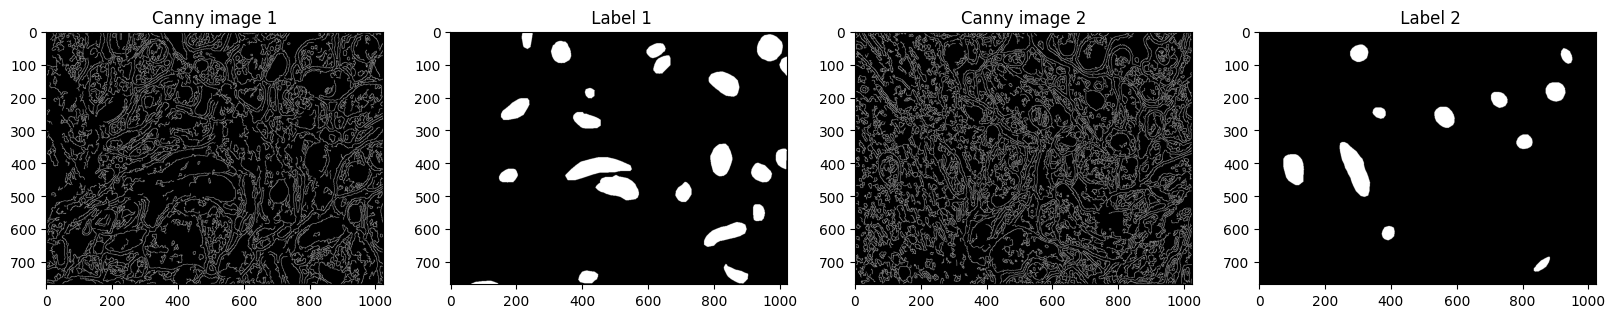

In [ ]:
#@markdown ## Edge detection image 2D
config = prep_cfg.clone()
config.CANNY.ENABLE = True
config.CANNY.LOW_THRESHOLD = None #@param {type:"raw"}
config.CANNY.HIGH_THRESHOLD = 90 #@param {type:"raw"}
config_name = 'Canny'

x,y = preprocess_data(config, x_data=[x1,x2], y_data=[y1,y2], is_2d=True, is_y_mask=True)
plot_images([x[0][...,0],y[0][...,0], x[1][...,0],y[1][...,0] ],
        title=[f'{config_name if i%2==0 else ""} '+ s for i,s in enumerate(data_title)])